<a href="https://colab.research.google.com/github/NataliaVrabcova/Assessment_2_Mini_Project/blob/main/MSO3255_Assessment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import string, re
import os
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    BertConfig,
    BertForQuestionAnswering
)



from google.colab import drive
drive.mount('/content/drive')



import torch.nn.utils.prune as prune

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [2]:
###############################################################################
# CONFIG
###############################################################################
TEACHER_MODEL_NAME = "bert-large-uncased-whole-word-masking-finetuned-squad"
MAX_LENGTH = 384
BATCH_SIZE = 8
EPOCHS = 2  # Increase for better results, # Note: One additional epoch is run immediately after pruning (total = 3 epochs)
LEARNING_RATE = 3e-5

# Distillation hyperparams
ALPHA = 0.5
TEMPERATURE = 4.0  # Temperature for soft logits

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)



Using device: cuda


In [3]:
###############################################################################
# 1) DATA LOADING & PREPROCESSING
###############################################################################
raw_squad = load_dataset("squad")

# For demonstration, we'll use the full training set or a subset
train_data = raw_squad["train"]
val_data = raw_squad["validation"]

tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME, use_fast=True)

def preprocess_function(ex):
    """
    Tokenize question + context and try to map answer start/end to token indices.
    We'll do a naive single-chunk approach (no sliding window).
    """
    # SQuAD "answers" has a list of possible answers; we take the first
    start_char = ex["answers"]["answer_start"][0]
    ans_texts = ex["answers"]["text"]
    answer_text = ans_texts[0] if len(ans_texts) > 0 else ""

    encoding = tokenizer(
        ex["question"],
        ex["context"],
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_offsets_mapping=True  # We'll use offsets for naive char->token mapping
    )

    offsets = encoding["offset_mapping"]
    input_ids = encoding["input_ids"]

    # Find start/end token indices
    start_token_idx = 0
    end_token_idx = 0

    # End char
    end_char = start_char + len(answer_text)

    # loop through offsets to find the best match
    for i, (off_start, off_end) in enumerate(offsets):
        # Some offsets may be None or special tokens
        if off_start is None or off_end is None:
            continue
        if off_start <= start_char < off_end:
            start_token_idx = i
        if off_start < end_char <= off_end:
            end_token_idx = i
            break

    if end_token_idx < start_token_idx:
        end_token_idx = start_token_idx

    # Store in encoding
    encoding["start_positions"] = start_token_idx
    encoding["end_positions"] = end_token_idx

    # Remove offset mapping to reduce data size
    encoding.pop("offset_mapping")

    return encoding

train_processed = train_data.map(preprocess_function)
val_processed   = val_data.map(preprocess_function)

# We'll convert to PyTorch Tensors
def to_tensor_dataset(hf_dataset):
    input_ids = torch.tensor(hf_dataset["input_ids"], dtype=torch.long)
    attention_mask = torch.tensor(hf_dataset["attention_mask"], dtype=torch.long)
    token_type_ids = torch.tensor(hf_dataset["token_type_ids"], dtype=torch.long) \
        if "token_type_ids" in hf_dataset.features else None
    start_positions = torch.tensor(hf_dataset["start_positions"], dtype=torch.long)
    end_positions   = torch.tensor(hf_dataset["end_positions"], dtype=torch.long)

    if token_type_ids is not None:
        return TensorDataset(input_ids, attention_mask, token_type_ids, start_positions, end_positions)
    else:
        # For models without token_type_ids (like DistilBERT)
        return TensorDataset(input_ids, attention_mask, start_positions, end_positions)

train_tds = to_tensor_dataset(train_processed)
val_tds   = to_tensor_dataset(val_processed)

train_loader = DataLoader(train_tds, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_tds,   batch_size=BATCH_SIZE, shuffle=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:

###############################################################################
# 2) TEACHER MODEL INFERENCE (collect teacher logits)
###############################################################################
teacher_model = AutoModelForQuestionAnswering.from_pretrained(TEACHER_MODEL_NAME).to(DEVICE)
teacher_model.eval()

teacher_start_logits_list = []
teacher_end_logits_list   = []
gt_start_list = []
gt_end_list   = []
input_tensors = []
count=0
with torch.no_grad():
    for batch in train_loader:
        count+=1
        print("batch", count)
        # batch can have 4 or 5 tensors depending on token_type_ids existence
        if len(batch) == 5:
            input_ids, attention_mask, token_type_ids, start_pos, end_pos = batch
            token_type_ids = token_type_ids.to(DEVICE)
        else:
            input_ids, attention_mask, start_pos, end_pos = batch
            token_type_ids = None

        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        start_pos = start_pos.to(DEVICE)
        end_pos   = end_pos.to(DEVICE)

        outputs = teacher_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        # Collect logits
        teacher_start_logits_list.append(outputs.start_logits.cpu())
        teacher_end_logits_list.append(outputs.end_logits.cpu())

        gt_start_list.append(start_pos.cpu())
        gt_end_list.append(end_pos.cpu())

        # We'll store the CPU tensors of inputs for the student dataset
        if token_type_ids is not None:
            input_tensors.append((input_ids.cpu(), attention_mask.cpu(), token_type_ids.cpu()))
        else:
            input_tensors.append((input_ids.cpu(), attention_mask.cpu(), None))

# Concatenate teacher outputs
teacher_start_logits_full = torch.cat(teacher_start_logits_list, dim=0)
teacher_end_logits_full   = torch.cat(teacher_end_logits_list, dim=0)
gt_start_full = torch.cat(gt_start_list, dim=0)
gt_end_full   = torch.cat(gt_end_list, dim=0)

# Flatten input tensors
all_input_ids         = []
all_attention_masks   = []
all_token_type_ids    = []
for batch_data in input_tensors:
    i_ids, i_mask, i_type = batch_data
    all_input_ids.append(i_ids)
    all_attention_masks.append(i_mask)
    if i_type is not None:
        all_token_type_ids.append(i_type)
    else:
        all_token_type_ids = None

all_input_ids       = torch.cat(all_input_ids, dim=0)
all_attention_masks = torch.cat(all_attention_masks, dim=0)
if all_token_type_ids is not None and len(all_token_type_ids) > 0:
    all_token_type_ids = torch.cat(all_token_type_ids, dim=0)

# Save teacher logits to Google Drive
LOGITS_PATH = "/content/drive/MyDrive/teacher_logits.pt"

torch.save({
    "start_logits": teacher_start_logits_full,
    "end_logits": teacher_end_logits_full,
    "gt_start": gt_start_full,
    "gt_end": gt_end_full,
    "input_ids": all_input_ids,
    "attention_mask": all_attention_masks,
    "token_type_ids": all_token_type_ids,
}, LOGITS_PATH)

print(f" Teacher logits saved successfully at: {LOGITS_PATH}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99
batch 100
batch 101
batch 102
batch 103
batch 104
batch 105
batch 106
batch 107
batch 108
batch 109
batch 110
batch 11

In [ ]:
# Set path to the saved logits file in Google Drive
LOGITS_PATH = "/content/drive/MyDrive/teacher_logits.pt"

# Check and load
if os.path.exists(LOGITS_PATH):
    print(f" Loading teacher logits from: {LOGITS_PATH}")
    data = torch.load(LOGITS_PATH)

    teacher_start_logits_full = data["start_logits"]
    teacher_end_logits_full   = data["end_logits"]
    gt_start_full             = data["gt_start"]
    gt_end_full               = data["gt_end"]
    all_input_ids             = data["input_ids"]
    all_attention_masks       = data["attention_mask"]
    all_token_type_ids        = data["token_type_ids"]

    print("Teacher logits loaded successfully!")
else:
    print(f"Teacher logits file not found at {LOGITS_PATH}. Please run inference to generate and save the logits first.")

teacher_model = AutoModelForQuestionAnswering.from_pretrained(TEACHER_MODEL_NAME).to(DEVICE)
teacher_model.eval()

In [5]:
from torch.utils.data import TensorDataset, DataLoader

# Convert teacher logits into probabilities using softmax with temperature
def softmax_with_temperature(logits, temperature):
    return torch.nn.functional.softmax(logits / temperature, dim=-1)

teacher_start_probs = softmax_with_temperature(teacher_start_logits_full, TEMPERATURE)
teacher_end_probs   = softmax_with_temperature(teacher_end_logits_full, TEMPERATURE)

# Construct distillation dataset
if all_token_type_ids is not None:
    distill_dataset = TensorDataset(
        all_input_ids,
        all_attention_masks,
        all_token_type_ids,
        teacher_start_probs,
        teacher_end_probs,
        gt_start_full,
        gt_end_full
    )
else:
    # For models without token_type_ids
    distill_dataset = TensorDataset(
        all_input_ids,
        all_attention_masks,
        torch.zeros_like(all_input_ids),  # dummy placeholder
        teacher_start_probs,
        teacher_end_probs,
        gt_start_full,
        gt_end_full
    )

# Define DataLoader
distill_loader = DataLoader(distill_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
###############################################################################
# 3) DEFINE A SMALLER STUDENT MODEL
###############################################################################
student_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=384,         # smaller hidden dim
    num_hidden_layers=8,     # fewer layers
    num_attention_heads=8,   # fewer heads
    intermediate_size=384 * 4,
    max_position_embeddings=MAX_LENGTH
)
student_model = BertForQuestionAnswering(student_config).to(DEVICE)


In [7]:
###############################################################################
# 4) Distillation + Pruning
###############################################################################

import torch.nn.utils.prune as prune
import torch.nn as nn

# Constants needed for distillation
TEACHER_LAYER_TO_MATCH = 8
STUDENT_LAYER_TO_MATCH = 4
HIDDEN_LOSS_WEIGHT = 0.3

# Loss and projection layer
mse_loss = nn.MSELoss()
project_teacher = nn.Linear(1024, 384).to(DEVICE)

# Define helper functions
def apply_pruning(model, amount=0.1):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def softmax_with_temperature(logits, temperature):
    return torch.nn.functional.softmax(logits / temperature, dim=-1)

# Apply pruning
apply_pruning(student_model, amount=0.1)
print("Applied pruning. Remaining trainable parameters:", count_parameters(student_model))

# Re-initialize optimizer after pruning
optimizer = torch.optim.AdamW(student_model.parameters(), lr=LEARNING_RATE)

# Distillation training step
def distillation_train_step(batch_data):
    if all_token_type_ids is not None:
        input_ids, attention_mask, token_type_ids, t_start_probs, t_end_probs, gt_start, gt_end = batch_data
        token_type_ids = token_type_ids.to(DEVICE)
    else:
        input_ids, attention_mask, _, t_start_probs, t_end_probs, gt_start, gt_end = batch_data
        token_type_ids = None

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    t_start_probs = t_start_probs.to(DEVICE)
    t_end_probs   = t_end_probs.to(DEVICE)
    gt_start = gt_start.to(DEVICE)
    gt_end   = gt_end.to(DEVICE)

    optimizer.zero_grad()

    with torch.no_grad():
        teacher_outputs = teacher_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True
        )
        teacher_hidden = teacher_outputs.hidden_states[TEACHER_LAYER_TO_MATCH]
        teacher_hidden_proj = project_teacher(teacher_hidden)

    student_outputs = student_model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        output_hidden_states=True
    )
    student_start_logits = student_outputs.start_logits
    student_end_logits   = student_outputs.end_logits
    student_hidden = student_outputs.hidden_states[STUDENT_LAYER_TO_MATCH]

    # Hard loss (cross-entropy with labels)
    ce_loss_fn = nn.CrossEntropyLoss()
    loss_start_hard = ce_loss_fn(student_start_logits, gt_start)
    loss_end_hard   = ce_loss_fn(student_end_logits,   gt_end)
    hard_loss = 0.5 * (loss_start_hard + loss_end_hard)

    # Soft loss (KL with teacher logits)
    s_start_probs = softmax_with_temperature(student_start_logits, TEMPERATURE)
    s_end_probs   = softmax_with_temperature(student_end_logits,   TEMPERATURE)

    kl_loss_fn = nn.KLDivLoss(reduction="batchmean")
    start_kl = kl_loss_fn(s_start_probs.log(), t_start_probs)
    end_kl   = kl_loss_fn(s_end_probs.log(),   t_end_probs)
    soft_loss = 0.5 * (start_kl + end_kl)

    # Hidden state loss (internal distillation)
    hidden_loss = mse_loss(student_hidden, teacher_hidden_proj)

    # Final loss
    loss = ALPHA * soft_loss + (1 - ALPHA) * hard_loss + HIDDEN_LOSS_WEIGHT * hidden_loss
    loss.backward()
    optimizer.step()

    return loss.item(), hard_loss.item(), soft_loss.item(), hidden_loss.item()

# Run one epoch of fine-tuning after pruning
print("\n Fine-tuning pruned model for 1 additional epoch...")
student_model.train()
epoch_losses = []

for step, batch_data in enumerate(distill_loader):
    loss_val, hard_val, soft_val, hidden_val = distillation_train_step(batch_data)
    epoch_losses.append(loss_val)
    if step % 200 == 0:
        print(f"  Step {step}: Total Loss = {loss_val:.4f} (Hard: {hard_val:.4f}, Soft: {soft_val:.4f}, Hidden: {hidden_val:.4f})")

print(f" Fine-tuning Loss (Epoch Avg): {np.mean(epoch_losses):.4f}")

Applied pruning. Remaining trainable parameters: 26065922

 Fine-tuning pruned model for 1 additional epoch...
  Step 0: Total Loss = 3.5454 (Hard: 5.8171, Soft: 0.5830, Hidden: 1.1511)
  Step 200: Total Loss = 2.6275 (Hard: 4.5192, Soft: 0.3332, Hidden: 0.6712)
  Step 400: Total Loss = 2.5740 (Hard: 4.3858, Soft: 0.3751, Hidden: 0.6452)
  Step 600: Total Loss = 2.7287 (Hard: 4.6722, Soft: 0.4369, Hidden: 0.5806)
 Fine-tuning Loss (Epoch Avg): 2.8136


In [13]:
###############################################################################
# 5) OFFICIAL POST-PROCESSING & EVALUATION (SQuAD Evaluation)
###############################################################################
!pip install evaluate

from evaluate import load as load_metric
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_tds, batch_size=8, shuffle=False)

student_model.eval()
predictions = {}
offset = 0

with torch.no_grad():
    for batch in val_dataloader:
        if len(batch) == 5:
            input_ids, attention_mask, token_type_ids, start_pos, end_pos = batch
            token_type_ids = token_type_ids.to(DEVICE)
        else:
            input_ids, attention_mask, start_pos, end_pos = batch
            token_type_ids = None

        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        outputs = student_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        start_logits = outputs.start_logits
        end_logits   = outputs.end_logits

        start_indices = torch.argmax(start_logits, dim=1).cpu().numpy()
        end_indices   = torch.argmax(end_logits,   dim=1).cpu().numpy()

        for i in range(len(start_indices)):
            idx = offset + i
            if idx >= len(val_data):
                continue

            s_ind = start_indices[i]
            e_ind = end_indices[i]
            if e_ind < s_ind:
                e_ind = s_ind

            tokens_ = input_ids[i][s_ind : e_ind+1].cpu().numpy().tolist()
            pred_text = tokenizer.decode(tokens_, skip_special_tokens=True)

            qa_id = val_data[idx]["id"]
            predictions[qa_id] = pred_text

        offset += len(start_indices)

# Load SQuAD v1 metric using new 'evaluate' library
metric = load_metric("squad")

formatted_predictions = [{"id": k, "prediction_text": v} for k, v in predictions.items()]
references = [{"id": item["id"], "answers": item["answers"]} for item in val_data]

results = metric.compute(predictions=formatted_predictions, references=references)

print(f"Exact Match: {results['exact_match']:.2f}%")
print(f"F1 Score:    {results['f1']:.2f}%")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00


Exact Match: 1.90%
F1 Score:    6.11%


In [14]:
# -----------------------------------------------
# 6. FINAL DEMONSTRATION: Validate Student Model
# -----------------------------------------------
def ask_question(question: str, context: str, model, tokenizer, device=DEVICE):
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    token_type_ids = inputs.get("token_type_ids")
    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    start_index = torch.argmax(start_logits, dim=1).item()
    end_index = torch.argmax(end_logits, dim=1).item()
    if end_index < start_index:
        end_index = start_index

    answer_ids = input_ids[0, start_index : end_index+1]
    answer_text = tokenizer.decode(answer_ids, skip_special_tokens=True)

    return answer_text

# Example 1
question1 = "Which city is Galatasaray based in?"
context1 = "Galatasaray, is a Turkish professional football club based on the European side of the city of Istanbul. It was founded in 1905."

teacher_model.eval()
student_model.eval()

teacher_answer1 = ask_question(question1, context1, teacher_model, tokenizer, device=DEVICE)
student_answer1 = ask_question(question1, context1, student_model, tokenizer, device=DEVICE)

print(f"[Teacher Answer]: {teacher_answer1}")
print(f"[Student Answer]: {student_answer1}")

# Example 2
question2 = "Who wrote the novel 1984?"
context2 = "George Orwell was a British author best known for his novels Animal Farm and 1984."

teacher_answer2 = ask_question(question2, context2, teacher_model, tokenizer, device=DEVICE)
student_answer2 = ask_question(question2, context2, student_model, tokenizer, device=DEVICE)

print(f"\nQuestion: {question2}")
print(f"[Teacher Answer]: {teacher_answer2}")
print(f"[Student Answer]: {student_answer2}")

[Teacher Answer]: istanbul
[Student Answer]: istanbul

Question: Who wrote the novel 1984?
[Teacher Answer]: george orwell
[Student Answer]: george


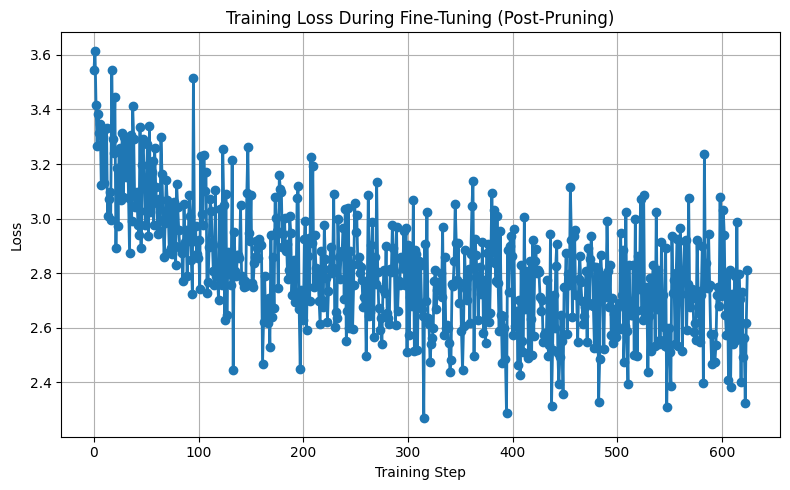

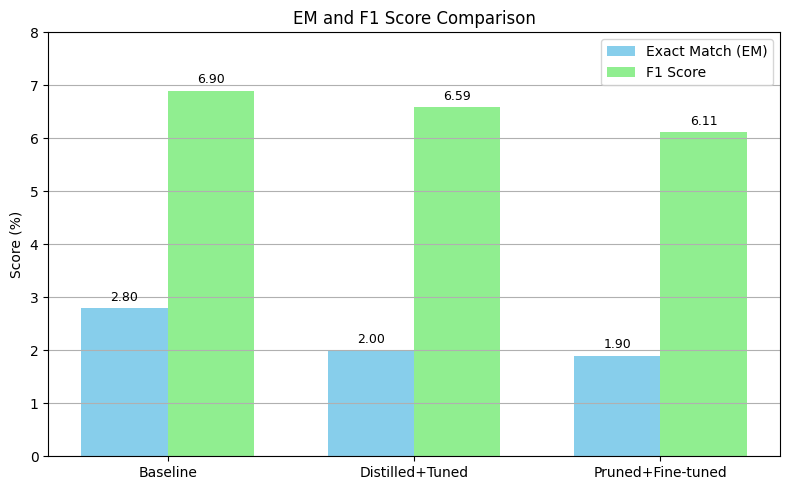

In [17]:
# -----------------------------------------------
# 7. FINAL VISUALIZATION: Loss Curves and Performance Comparison
# -----------------------------------------------
import matplotlib.pyplot as plt
# Plot 1: Training Loss Curve
plt.figure(figsize=(8,5))
plt.plot(epoch_losses, marker='o', linewidth=2)
plt.title("Training Loss During Fine-Tuning (Post-Pruning)")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2:
# EM and F1 scores for the three models
labels = ["Baseline", "Distilled+Tuned", "Pruned+Fine-tuned"]
em_scores = [2.80, 2.00, 1.90]
f1_scores = [6.90, 6.59, 6.11]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width / 2, em_scores, width, label='Exact Match (EM)', color='skyblue')
rects2 = ax.bar(x + width / 2, f1_scores, width, label='F1 Score', color='lightgreen')

# Add score labels on top of each bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_labels(rects1)
add_labels(rects2)

# Format axes
ax.set_ylabel('Score (%)')
ax.set_title('EM and F1 Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 8)  # Adjust based on your values
ax.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()